# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy

import sys
import os

import torch
from src.visualize import plot_two_turbine_results

from pyomo.environ import value


#from src.visualize import plot_optimization_results

sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl



## Load Data

In [2]:
# Load Data
data = pd.read_csv("data/two_turbine_deterministic270.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,50.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,100.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,150.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,200.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918


# Train NN and generate constraints

In [3]:
# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

In [5]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2","wind_speed", "wind_direction", "turbulence_intensity"]],#, "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

# Load a pre-trained model from the /models directory

# Retrain the model with the best parameters
#model_nn, preds_test, y_test = cl_tool.train(n_hidden=2, n_nodes=8, iters=1000, drop=0.05, learning_rate=1e-4)

model_nn = cl_tool.load_model(path="models/nn_deterministic_2hidden_10nodes.pth")

In [6]:
cons = cl_tool.constraint_build(model_nn)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7
0,-0.133561,0,0,-0.003348,0.239905,-0.368077,-0.433995,-0.394909,NaN,NaN,NaN
1,0.218851,0,1,0.119924,-0.008861,0.354591,-0.534763,0.706933,NaN,NaN,NaN
2,-0.401765,0,2,-0.135154,-0.087907,-0.427245,-0.430024,-0.349406,NaN,NaN,NaN
3,-0.816430,0,3,0.016566,0.176799,0.268338,-0.411618,-0.417629,NaN,NaN,NaN
4,-0.197187,0,4,0.162436,0.371361,-0.092037,-0.096799,-0.379587,NaN,NaN,NaN
5,-0.619053,0,5,0.047322,0.404941,-0.414867,-0.385692,-0.346952,NaN,NaN,NaN
6,0.248484,0,6,-0.174324,0.386393,-0.289875,-0.317316,-0.225395,NaN,NaN,NaN
7,0.619300,0,7,-0.418843,-0.261057,0.384424,-0.309694,0.723779,NaN,NaN,NaN
0,-0.329962,1,0,-0.200823,0.037883,0.087841,0.172710,-0.130395,-0.098075,0.146270,-0.121576
1,0.521221,1,1,0.042566,-0.157555,-0.075882,-0.873746,-0.222880,-0.224627,-0.180600,0.127902


# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


In [7]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

contextual_sample = data[["x_turb2", "y_turb2","wind_speed",  "wind_direction", "turbulence_intensity"]].iloc[[0]]
model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # model output

model.power = pyo.Var(within=pyo.Reals) # saving power per scenario

model.min_dist = pyo.Param(initialize=100, mutable=False)
model.x_max = pyo.Param(initialize=4000, mutable=False)
model.y_max = pyo.Param(initialize=500, mutable=False)

# obj function 
def obj_expression(model):
    return model.power
model.obj = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model):
    return model.power == model.y['power', 0, 1]
model.const_power = pyo.Constraint(rule=power)

#constraint for fixing contextual information
def fix_vars(model,x_ind):
    if x_ind=='x_turb2':
        return pyo.Constraint.Skip
    if x_ind=='y_turb2':
        return pyo.Constraint.Skip
    else:
        return model.x[x_ind] == contextual_sample.loc[0,x_ind]
model.const_fix_vars = pyo.Constraint(model.var_ind, rule=fix_vars)

# upper limits for x_turb2 and y_turb2
model.x_turb2_ub = pyo.Constraint(expr=model.x['x_turb2'] <= model.x_max)  # Upper bound
model.y_turb2_ub = pyo.Constraint(expr=model.x['y_turb2'] <= model.y_max)   # Upper bound

# lower limits for x_turb2 and y_turb2
model.x_turb2_lb = pyo.Constraint(expr=model.x['x_turb2'] >= 0)  # Lower bound
model.y_turb2_lb = pyo.Constraint(expr=model.x['y_turb2'] >= 0)   # Lower bound

# lower limits for x_turb2 and y_turb2
def distance_constraint(model):
    return ((model.x["x_turb2"] - 0)**2 + (model.x["y_turb2"] - 0)**2) >= model.min_dist**2 
model.distance_constraint = Constraint(rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed(opt_model=model, constaints=cons, outcome='power', deterministic = True)


Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power


In [8]:
# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmpgr1jtbil.pyomo.lp
Reading time = 0.00 seconds
x1: 58 rows, 40 columns, 308 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 58 rows, 40 columns and 308 nonzeros
Model fingerprint: 0x46f67bfe
Model has 1 quadratic constraint
Variable types: 24 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [7e-05, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 4e+03]
  QRHS range       [1e+04, 1e+04]
Presolve removed 14 rows and 10 columns
Presolve time: 0.00s
Presolved: 47 rows, 33 columns, 232

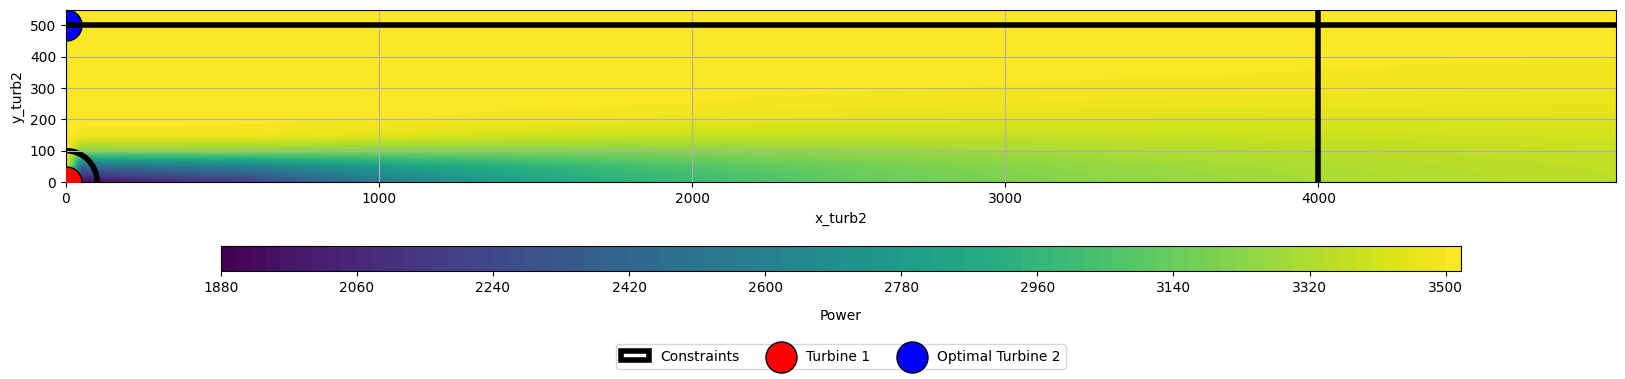


Optimization Results:

Contextual/Decision Variables (x):
turbulence_intensity: 0.06
wind_direction: 270.0
wind_speed: 8.0
x_turb2: 0.0
y_turb2: 500.0
Optimal objective value: 3513.469573097882


In [9]:
# get resulsts
plot_two_turbine_results(data, zfeature='farm_power', model_opt=model)


print("\nOptimization Results:")
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")
print("Optimal objective value:", value(model.obj))


In [10]:
# verify obj function value is correct
cl_tool.predict(X=pd.DataFrame({
    "x_turb2": [value(model.x["x_turb2"])],
    "y_turb2": [value(model.x["y_turb2"])],
    "wind_speed": [contextual_sample.loc[0, "wind_speed"]],
    "wind_direction": [contextual_sample.loc[0, "wind_direction"]],
    "turbulence_intensity": [contextual_sample.loc[0, "turbulence_intensity"]]
}))

array([[3513.4695]], dtype=float32)